In [1]:
# RMIT University in Vietnam
# Course: EEET2574 Big Data in Engineering
# Semester: 2020B
# Assessment: Big Data Project

# Authors: Group 14
#   Nguyen Minh Trang (s3751450)
#   Nguyen Manh Triet (s3678932)
#   Nguyen Minh Tri (s3726096)
#   Vang Huynh Minh Tri (s3726101)

# Created date: 15/09/2020
# Last modified date: 27/09/2020

# Libraries Installation


In [2]:
#Run this cell to download libraries
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install sklearn
# !pip install graphviz
# !pip install pydotplus
# !brew install graphviz

Updating Homebrew...
==> Auto-updated Homebrew!
Updated 1 tap (homebrew/core).
==> New Formulae
leaf
==> Updated Formulae
Updated 48 formulae.

To reinstall 2.44.1, run `brew reinstall graphviz`


In [2]:
#Libraries to process data
import numpy as np
import pandas as pd
from collections import Counter

#Libraries to visualize data
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text
from sklearn.tree import export_graphviz
import graphviz
from sklearn import tree
from io import StringIO
from IPython.display import Image  
import pydotplus
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text

#Libraries to train models
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB

#Libraries to select features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Data Files Loading

In [3]:
CRSS_path = "/Users/nguyenmanhtriet/Documents/Big Data Notebooks/Big Data Project/CRSS2018CSV/"

#Read data from csv files
person = pd.read_csv(CRSS_path+"PERSON.csv",header=0)
accident = pd.read_csv(CRSS_path+"ACCIDENT.csv",header=0)
vehicle = pd.read_csv(CRSS_path+"VEHICLE.csv",header=0)
violation = pd.read_csv(CRSS_path+'VIOLATN.csv',header=0)
distract = pd.read_csv(CRSS_path+'DISTRACT.csv',header=0)
drimpair = pd.read_csv(CRSS_path+'DRIMPAIR.csv',header=0)

# Data Visualization

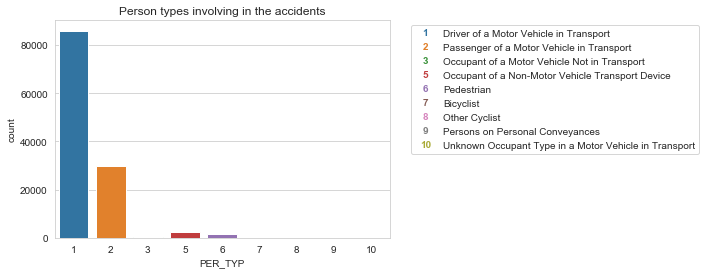

In [4]:
#Plot the frequency of person types involving in accidents
ax = sns.countplot(x='PER_TYP', data=person)
ax.set_title("Person types involving in the accidents")

# Add custom legend for clarity
class TextHandler(HandlerBase):
    def create_artists(self, legend, tup, xdescent, ydescent, width, height,
                       fontsize, trans):
        tx = Text(width / 2,
                  height / 2,
                  tup[0],
                  fontsize=fontsize,
                  fontweight='bold',
                  ha='center',
                  va='center',
                  color=tup[1])
        return [tx]
xticks = ax.get_xticklabels()
handles = [(handle.get_text(), color.get_fc())
           for handle, color in zip(xticks, ax.patches)]
labels = [
    'Driver of a Motor Vehicle in Transport', 
    'Passenger of a Motor Vehicle in Transport', 
    'Occupant of a Motor Vehicle Not in Transport',
    'Occupant of a Non-Motor Vehicle Transport Device', 
    'Pedestrian', 
    'Bicyclist',
    'Other Cyclist', 
    'Persons on Personal Conveyances',
    'Unknown Occupant Type in a Motor Vehicle in Transport',
    'Persons in or on Buildings',
    'Unknown Type of Non-Motorist'
]
ax.legend(handles,
          labels,
          handler_map={tuple: TextHandler()},
          bbox_to_anchor=(1.05, 1),
          loc='upper left')

In [5]:
#Focus on drivers and passengers only (motorists = drivers + passengers)
motorist = person.loc[(person['PER_TYP']==1) | (person['PER_TYP']==2)]

#Merging data: Accident + Vehicle + Person (PER_TYP = driver (1) + PER_TYP = passenger (2))
#Accident + Vehicle
cols_to_use = vehicle.columns.difference(accident.columns)
acc_veh = pd.merge(accident, vehicle[cols_to_use.insert(0,'CASENUM')], 
                   how='inner', on='CASENUM')
#Accident + Vehicle + Driver
cols_to_use = motorist.columns.difference(acc_veh.columns)
acc_veh_mot = pd.merge(acc_veh,motorist[(cols_to_use.insert(0,'CASENUM')).insert(1,'VEH_NO')],
                       how='inner', on=['CASENUM','VEH_NO'])
# #Attach cols in Violation, Distract, Drimpair to the main dataset
cols_to_use = violation.columns.difference(acc_veh_mot.columns)
acc_veh_mot = pd.merge(acc_veh_mot,violation[(cols_to_use.insert(0,'CASENUM')).insert(1,'VEH_NO')],
                       how='inner',on=['CASENUM','VEH_NO'])
cols_to_use = distract.columns.difference(acc_veh_mot.columns)
acc_veh_mot = pd.merge(acc_veh_mot,distract[(cols_to_use.insert(0,'CASENUM')).insert(1,'VEH_NO')],
                       how='inner',on=['CASENUM','VEH_NO'])
cols_to_use = drimpair.columns.difference(acc_veh_mot.columns)
acc_veh_mot = pd.merge(acc_veh_mot,drimpair[(cols_to_use.insert(0,'CASENUM')).insert(1,'VEH_NO')],
                       how='inner',on=['CASENUM','VEH_NO'])

In [24]:
#Print the shape of the whole data
print('Pre-processing data shape:',acc_veh_mot.shape[0],'rows,',acc_veh_mot.shape[1],'columns')

Pre-processing data shape: 123144 rows, 153 columns


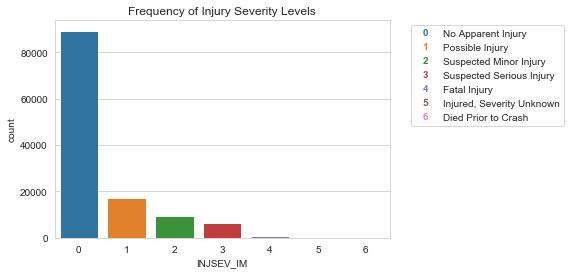

In [25]:
#Plot the frequency of person types involving in accidents
ax = sns.countplot(x='INJSEV_IM', data=acc_veh_mot)
ax.set_title("Frequency of Injury Severity Levels")

# Add custom legend for clarity
class TextHandler(HandlerBase):
    def create_artists(self, legend, tup, xdescent, ydescent, width, height,
                       fontsize, trans):
        tx = Text(width / 2,
                  height / 2,
                  tup[0],
                  fontsize=fontsize,
                  fontweight='bold',
                  ha='center',
                  va='center',
                  color=tup[1])
        return [tx]
xticks = ax.get_xticklabels()
handles = [(handle.get_text(), color.get_fc())
           for handle, color in zip(xticks, ax.patches)]
labels = [
    'No Apparent Injury', 
    'Possible Injury', 
    'Suspected Minor Injury',
    'Suspected Serious Injury', 
    'Fatal Injury', 
    'Injured, Severity Unknown',
    'Died Prior to Crash', 
    'Unknown/Not Reported'
]
ax.legend(handles,
          labels,
          handler_map={tuple: TextHandler()},
          bbox_to_anchor=(1.05, 1),
          loc='upper left')

Text(0.5, 1.0, 'Frequency of Injury Severity Levels')

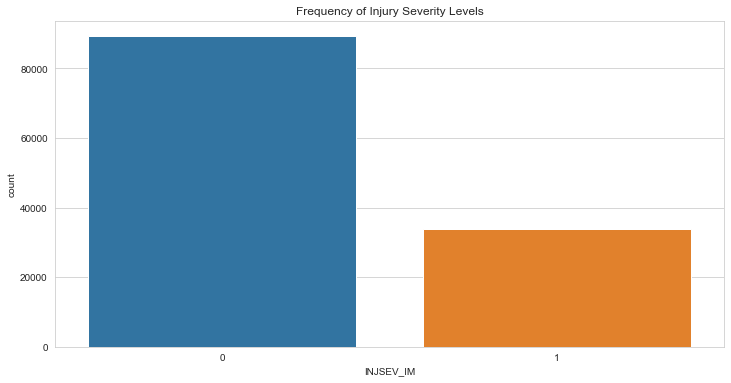

In [26]:
#Replace all the severity levels from 1 to 4 with 1 (Injured)
#0 means no apparent injury 
acc_veh_mot.loc[(acc_veh_mot['INJSEV_IM'] >= 1), 'INJSEV_IM'] = 1
plt.figure(figsize=(12, 6))
sns.countplot(acc_veh_mot['INJSEV_IM']).set_title("Frequency of Injury Severity Levels")

In [27]:
#Count and percentage of each class
counter = Counter(acc_veh_mot['INJSEV_IM'].sort_values())
for element, count in counter.items():
    print("Class", element, count, "{0:.0%}".format(count/len(acc_veh_mot)))

Class 0 89265 72%
Class 1 33879 28%


# Data Cleaning

In [7]:
#Check whether the merged dataset contains any NaNs or null values 
acc_veh_mot.isna().sum().sum()

0

### The dataset is already cleaned so that it is sufficient enough for following tasks

# Features Selection

In [29]:
#Selecting relating columns based on domain knowledge in:
#Accident file
acc_rel_cols = ['URBANICITY', 'MONTH', 'WKDY_IM', 'HOUR_IM', 'MINUTE_IM', 'RELJCT1_IM', 'REL_ROAD', 'TYP_INT', 'LGTCON_IM','WEATHR_IM','INT_HWY']
#Vehicle file
veh_rel_cols = ['HITRUN_IM', 'BDYTYP_IM', 'MDLYR_IM', 'GVWR', 'HAZ_INV', 'V_ALCH_IM', 'SPEEDREL', 'VTRAFWAY', 'VNUM_LAN', 'VALIGN', 'VPROFILE', 'VSURCOND', 'VTRAFCON', 'VTCONT_F']
#Person file
per_rel_cols = ['AGE_IM', 'SEX_IM', 'INJSEV_IM', 'SEAT_IM']
#Violation file
violation_rel_cols = ['MVIOLATN']
#Distract file
distract_rel_cols = ['MDRDSTRD']
#Drimpair file
drimpair_rel_cols = ['DRIMPAIR']

#Get rid of irrelevant attributes
acc_veh_mot = acc_veh_mot[acc_rel_cols + veh_rel_cols + per_rel_cols + violation_rel_cols + distract_rel_cols + drimpair_rel_cols]

# Data Aggregation

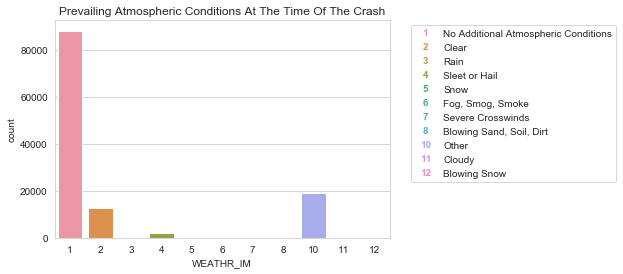

In [32]:
ax = sns.countplot(x='WEATHR_IM', data=acc_veh_mot)
ax.set_title("Prevailing Atmospheric Conditions At The Time Of The Crash")

# Add custom legend for clarity
class TextHandler(HandlerBase):
    def create_artists(self, legend, tup, xdescent, ydescent, width, height,
                       fontsize, trans):
        tx = Text(width / 2,
                  height / 2,
                  tup[0],
                  fontsize=fontsize,
                  fontweight='bold',
                  ha='center',
                  va='center',
                  color=tup[1])
        return [tx]
xticks = ax.get_xticklabels()
handles = [(handle.get_text(), color.get_fc())
           for handle, color in zip(xticks, ax.patches)]
labels = [
    'No Additional Atmospheric Conditions', 
    'Clear', 
    'Rain',
    'Sleet or Hail', 
    'Snow', 
    'Fog, Smog, Smoke',
    'Severe Crosswinds', 
    'Blowing Sand, Soil, Dirt',
    'Other',
    'Cloudy',
    'Blowing Snow',
    'Freezing Rain or Drizzle'
]
ax.legend(handles,
          labels,
          handler_map={tuple: TextHandler()},
          bbox_to_anchor=(1.05, 1),
          loc='upper left')

In [34]:
#Clean attributes from Accident file
acc_veh_mot.loc[(acc_veh_mot['WEATHR_IM'] == 1), 'WEATHR_IM'] = 0
acc_veh_mot.loc[(acc_veh_mot['WEATHR_IM'] > 1), 'WEATHR_IM'] = 1

Text(0.5, 1.0, 'Prevailing Atmospheric Conditions At The Time Of The Crash ')

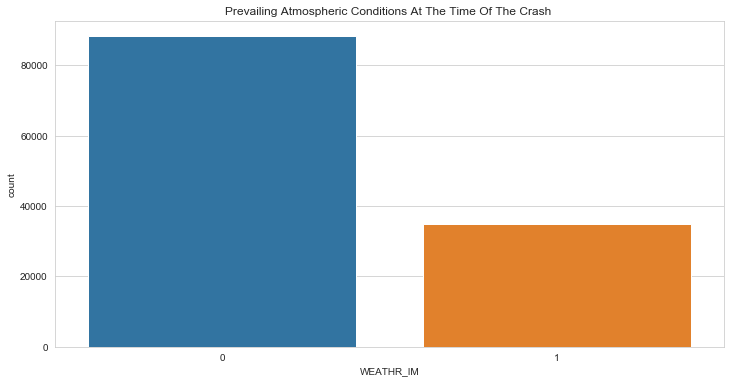

In [19]:
plt.figure(figsize=(12, 6))
sns.countplot(acc_veh_mot['WEATHR_IM']).set_title("Prevailing Atmospheric Conditions At The Time Of The Crash")

In [10]:
#Print the shape of the whole data after selecting attributes
print('Data shape:',acc_veh_mot.shape[0],'rows,',acc_veh_mot.shape[1],'columns')

Data shape: 123144 rows, 32 columns


In [11]:
acc_veh_mot.describe()

URBANICITY          MONTH        WKDY_IM        HOUR_IM  \
count  123144.000000  123144.000000  123144.000000  123144.000000   
mean        1.205792       6.649345       4.136686      13.562001   
std         0.404281       3.421844       1.926896       5.181610   
min         1.000000       1.000000       1.000000       0.000000   
25%         1.000000       4.000000       2.000000      10.000000   
50%         1.000000       7.000000       4.000000      14.000000   
75%         1.000000      10.000000       6.000000      17.000000   
max         2.000000      12.000000       7.000000      23.000000   

           MINUTE_IM     RELJCT1_IM       REL_ROAD        TYP_INT  \
count  123144.000000  123144.000000  123144.000000  123144.000000   
mean       28.364939       0.037241       1.479690      13.102132   
std        17.552458       0.189352       2.727242      31.305567   
min         0.000000       0.000000       1.000000       1.000000   
25%        14.000000       0.000000       1.000000       1.000000   
50%        29.000000       0.000000       1.000000       1.000000   
75%        44.000000       0.000000       1.000000       2.000000   
max        59.000000       1.000000      99.000000      99.000000   

           LGTCON_IM      WEATHR_IM  ...       VSURCOND       VTRAFCON  \
count  123144.000000  123144.000000  ...  123144.000000  123144.000000   
mean        1.567246       2.594564  ...       2.522859       6.315898   
std         1.021476       3.252429  ...      11.239117      18.463320   
min         1.000000       1.000000  ...       0.000000       0.000000   
25%         1.000000       1.000000  ...       1.000000       0.000000   
50%         1.000000       1.000000  ...       1.000000       0.000000   
75%         2.000000       2.000000  ...       1.000000       3.000000   
max         7.000000      12.000000  ...      99.000000      99.000000   

            VTCONT_F         AGE_IM         SEX_IM      INJSEV_IM  \
count  123144.000000  123144.000000  123144.000000  123144.000000   
mean        1.283132      36.952348       1.451317       0.275117   
std         1.816712      18.878474       0.497626       0.446575   
min         0.000000       0.000000       1.000000       0.000000   
25%         0.000000      22.000000       1.000000       0.000000   
50%         0.000000      34.000000       1.000000       0.000000   
75%         3.000000      51.000000       2.000000       1.000000   
max         9.000000     117.000000       2.000000       1.000000   

             SEAT_IM       MVIOLATN       MDRDSTRD       DRIMPAIR  
count  123144.000000  123144.000000  123144.000000  123144.000000  
mean       12.647323      14.639049      34.936392       9.503191  
std         4.157369      28.176682      45.815108      28.481662  
min        11.000000       0.000000       0.000000       0.000000  
25%        11.000000       0.000000       0.000000       0.000000  
50%        11.000000       0.000000       0.000000       0.000000  
75%        13.000000       4.000000      96.000000       0.000000  
max        55.000000      99.000000      99.000000      99.000000  

[8 rows x 32 columns]

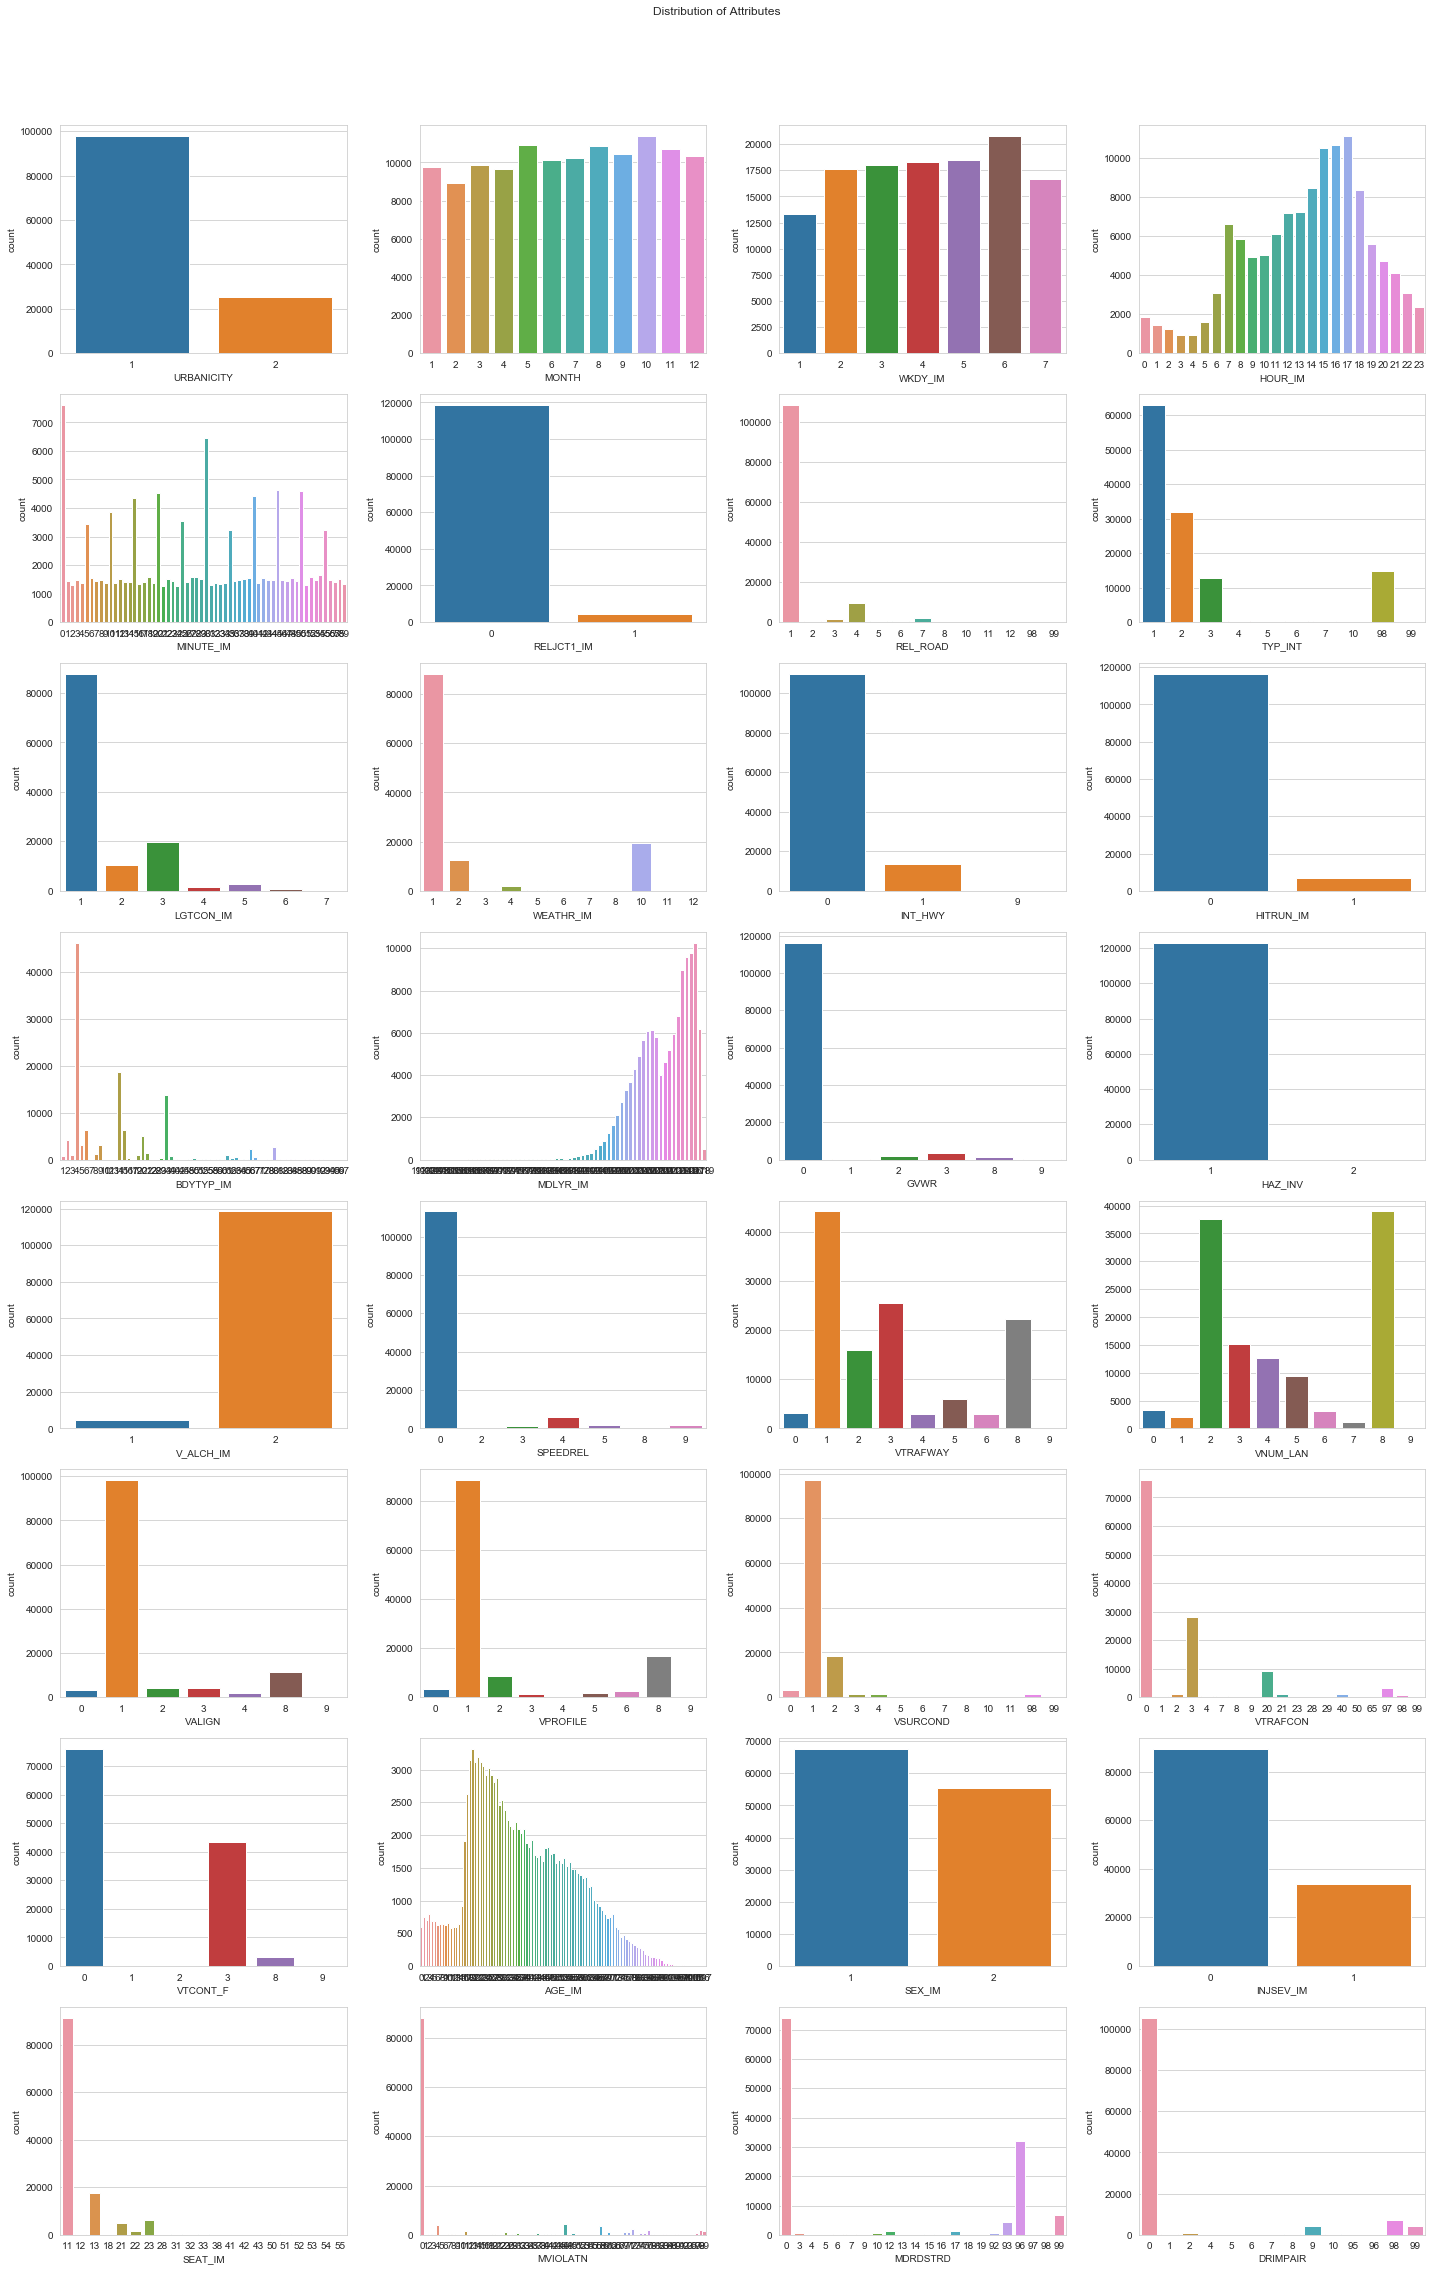

In [12]:
#Plot the distribution of the above attributes
rel_cols = acc_rel_cols + veh_rel_cols + per_rel_cols + ['MVIOLATN', "MDRDSTRD", 'DRIMPAIR']
fig, axes = plt.subplots(8, 4, figsize=(20, 30))
i = 0
j = 0
for col in rel_cols:
    # Create countplot in grid
    sns.countplot(acc_veh_mot[col], ax=axes[i, j])
    j += 1 # Increment column
    if (j >= 4): # If past last column
        j = 0 # Reset column
        i += 1 # Next row

plt.suptitle("Distribution of Attributes", y = 1.05)
plt.tight_layout()

In [13]:
#Drop attributes with bias distribution
drop_cols = ['RELJCT1_IM', 'REL_ROAD', 'INT_HWY', 'HITRUN_IM', 'GVWR', 'HAZ_INV', 'V_ALCH_IM', 'SPEEDREL', 'VALIGN', 'VPROFILE', 'VSURCOND', 'VTRAFCON', 'SEAT_IM', 'MVIOLATN', 'MDRDSTRD', 'DRIMPAIR','TYP_INT','BDYTYP_IM','VTRAFWAY','VNUM_LAN']
acc_veh_mot = acc_veh_mot.drop(drop_cols, axis=1)
#Remaining columns
acc_veh_mot.columns

Index(['URBANICITY', 'MONTH', 'WKDY_IM', 'HOUR_IM', 'MINUTE_IM', 'LGTCON_IM',
       'WEATHR_IM', 'MDLYR_IM', 'VTCONT_F', 'AGE_IM', 'SEX_IM', 'INJSEV_IM'],
      dtype='object')

In [14]:
#Print the shape of the whole data after dropping irrelevant features
print('Data shape:',acc_veh_mot.shape[0],'rows,',acc_veh_mot.shape[1],'columns')

Data shape: 123144 rows, 12 columns


In [16]:
#Print the shape of the whole data after cleaning features
print('Data shape:',acc_veh_mot.shape[0],'rows,',acc_veh_mot.shape[1],'columns')

Data shape: 123144 rows, 12 columns


In [17]:
acc_veh_mot[['URBANICITY', 'MONTH', 'WKDY_IM', 'HOUR_IM', 'MINUTE_IM', 'LGTCON_IM']].describe()

URBANICITY          MONTH        WKDY_IM        HOUR_IM  \
count  123144.000000  123144.000000  123144.000000  123144.000000   
mean        1.205792       6.649345       4.136686      13.562001   
std         0.404281       3.421844       1.926896       5.181610   
min         1.000000       1.000000       1.000000       0.000000   
25%         1.000000       4.000000       2.000000      10.000000   
50%         1.000000       7.000000       4.000000      14.000000   
75%         1.000000      10.000000       6.000000      17.000000   
max         2.000000      12.000000       7.000000      23.000000   

           MINUTE_IM      LGTCON_IM  
count  123144.000000  123144.000000  
mean       28.364939       1.567246  
std        17.552458       1.021476  
min         0.000000       1.000000  
25%        14.000000       1.000000  
50%        29.000000       1.000000  
75%        44.000000       2.000000  
max        59.000000       7.000000

In [18]:
acc_veh_mot[['WEATHR_IM', 'MDLYR_IM', 'VTCONT_F', 'AGE_IM', 'SEX_IM', 'INJSEV_IM']].describe()

WEATHR_IM       MDLYR_IM       VTCONT_F         AGE_IM  \
count  123144.000000  123144.000000  123144.000000  123144.000000   
mean        0.283627    2009.580264       1.283132      36.952348   
std         0.450760       6.525263       1.816712      18.878474   
min         0.000000    1931.000000       0.000000       0.000000   
25%         0.000000    2005.000000       0.000000      22.000000   
50%         0.000000    2011.000000       0.000000      34.000000   
75%         1.000000    2015.000000       3.000000      51.000000   
max         1.000000    2019.000000       9.000000     117.000000   

              SEX_IM      INJSEV_IM  
count  123144.000000  123144.000000  
mean        1.451317       0.275117  
std         0.497626       0.446575  
min         1.000000       0.000000  
25%         1.000000       0.000000  
50%         1.000000       0.000000  
75%         2.000000       1.000000  
max         2.000000       1.000000

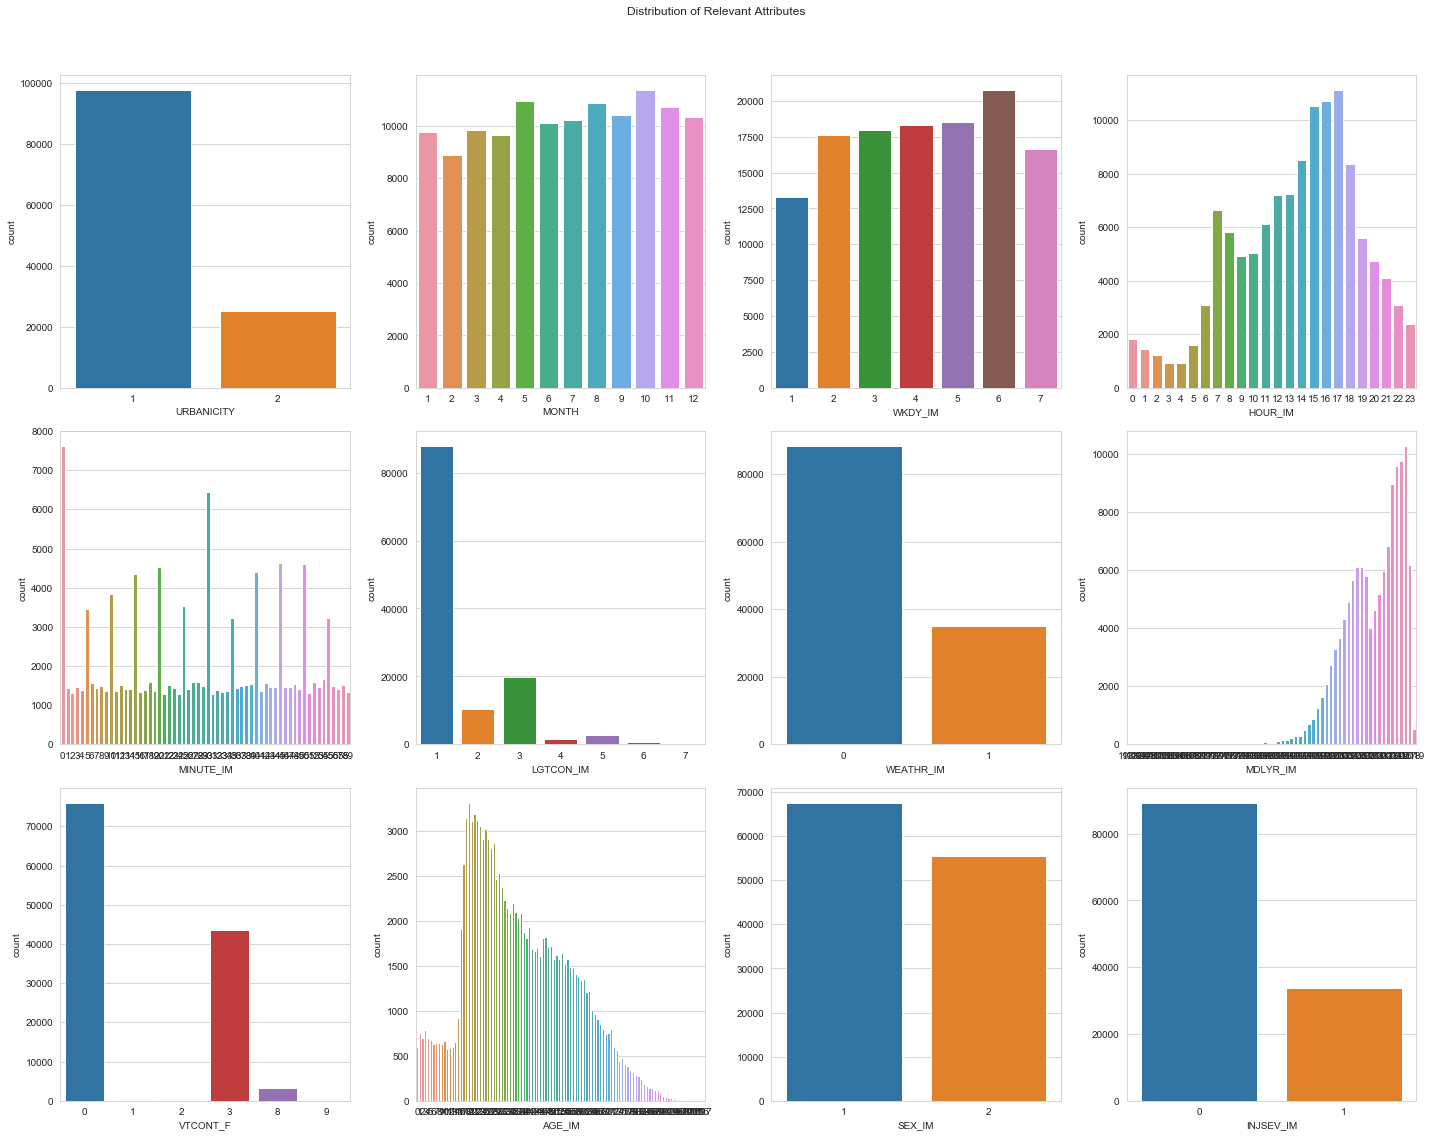

In [36]:
#Plot the distribution of the chosen attributes
rel_cols = acc_veh_mot.columns
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
i = 0
j = 0
for col in rel_cols:
    # Create countplot in grid
    sns.countplot(acc_veh_mot[col], ax=axes[i, j])
    j += 1 # Increment column
    if (j >= 4): # If past last column
        j = 0 # Reset column
        i += 1 # Next row

plt.suptitle("Distribution of Relevant Attributes", y = 1.05)
plt.tight_layout()

# Build Decision Tree with K-Fold = 5

In [22]:
#Data for training models
X_motorist = np.array(acc_veh_mot.drop(['INJSEV_IM'],axis=1))
y_motorist = np.array(acc_veh_mot['INJSEV_IM'])

In [23]:
#Decision Tree
param_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 100]
}
gridSearchCV = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=5, refit=True)
gridSearchCV.fit(X_motorist,y_motorist)

print(gridSearchCV.best_score_)
print(gridSearchCV.best_estimator_)

0.7250292307635797
DecisionTreeClassifier(criterion='entropy', max_depth=5)


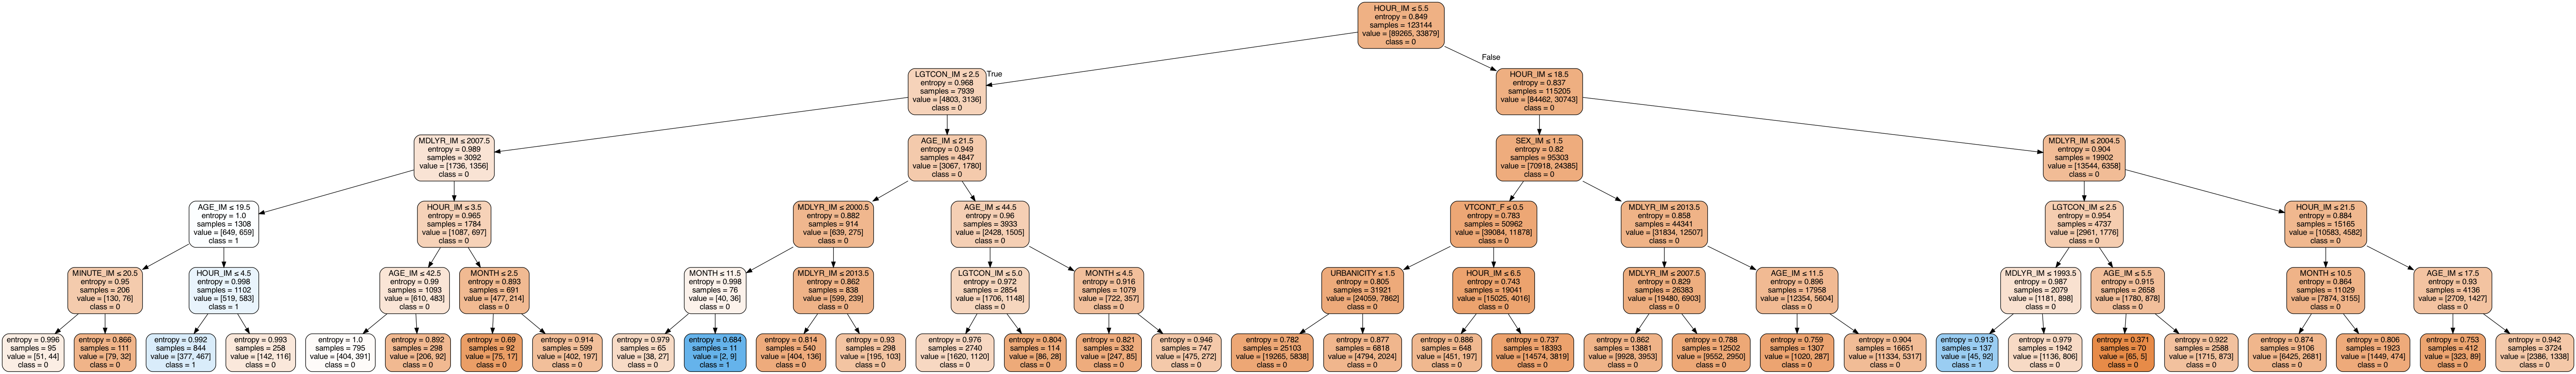

In [24]:
dot_data = StringIO()
export_graphviz(gridSearchCV.best_estimator_, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names = acc_veh_mot.drop(["INJSEV_IM"], axis=1).columns,
                class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
graph.write_png('result.png')
Image(graph.create_png())

# Select Features using Chi-2

In [25]:
# Select train and test data
X_motorist = acc_veh_mot.drop(columns=['INJSEV_IM'])
y_motorist = acc_veh_mot.INJSEV_IM

# Build model
selector = SelectKBest(chi2, k='all')
selector.fit(X_motorist, y_motorist)

# List of features with chi2 scores
d = {'FEATURE':X_motorist.columns, 'CHI2_SCORE':selector.scores_, 'P_VALUE':selector.pvalues_}
chi_features = pd.DataFrame(d)
chi_features_sorted = chi_features.sort_values(by=['CHI2_SCORE', 'P_VALUE'], ascending=False)
chi_features_sorted.reset_index(drop=True, inplace=True)
chi_features_sorted

FEATURE   CHI2_SCORE        P_VALUE
0       AGE_IM  1076.281273  4.721344e-236
1     VTCONT_F   215.884247   7.147794e-49
2    LGTCON_IM   103.848747   2.183659e-24
3      HOUR_IM    65.033000   7.365424e-16
4       SEX_IM    37.287794   1.019205e-09
5   URBANICITY    15.249319   9.421074e-05
6      WKDY_IM    12.809844   3.448004e-04
7    WEATHR_IM     2.315923   1.280553e-01
8    MINUTE_IM     1.323682   2.499323e-01
9     MDLYR_IM     0.570200   4.501796e-01
10       MONTH     0.118617   7.305388e-01

In [26]:
#Decision Tree with dropped high-chi-squared attributes
#Data for training models
X_motorist = np.array(acc_veh_mot.drop(['AGE_IM','VTCONT_F','LGTCON_IM','HOUR_IM','SEX_IM','URBANICITY','WKDY_IM','INJSEV_IM'],axis=1))
y_motorist = np.array(acc_veh_mot['INJSEV_IM'])

param_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 100]
}
gridSearchCV = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=5, refit=True)
gridSearchCV.fit(X_motorist,y_motorist)

print(gridSearchCV.best_score_)
print(gridSearchCV.best_estimator_)

0.7245501187929342
DecisionTreeClassifier(max_depth=5)


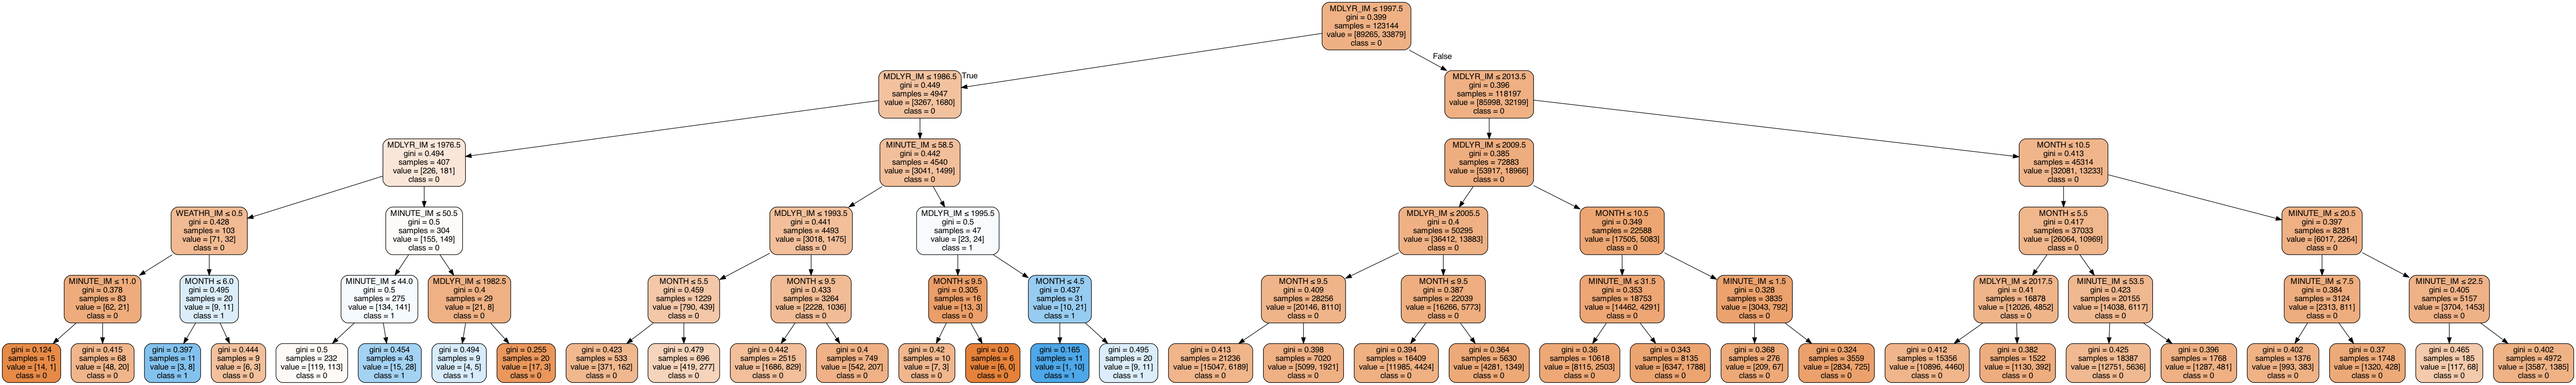

In [27]:
dot_data = StringIO()
export_graphviz(gridSearchCV.best_estimator_, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = acc_veh_mot.drop(['AGE_IM','VTCONT_F','LGTCON_IM','HOUR_IM','SEX_IM','URBANICITY','WKDY_IM','INJSEV_IM'], axis=1).columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# Comparing models using Classification-Report

In [28]:
# Split data 80% training, 20% testing
X_train,X_test,y_train,y_test = train_test_split(np.array(acc_veh_mot.drop(columns=['INJSEV_IM'])), 
                                                np.array(acc_veh_mot.INJSEV_IM), 
                                                test_size=0.2,
                                                random_state=99)


print('X train shape:',X_train.shape)
print('X test shape:',X_test.shape)
print('y train shape:',y_train.shape)
print('y test shape:',y_test.shape)

X train shape: (98515, 11)
X test shape: (24629, 11)
y train shape: (98515,)
y test shape: (24629,)


In [29]:
# Decision Tree Classification model (no hyper-parameter tuning applied)
tree_model = DecisionTreeClassifier(criterion='gini', random_state=99)
tree_model = tree_model.fit(X_train, y_train)

predictions = tree_model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.78      0.75      0.77     17997
           1       0.39      0.43      0.41      6632

    accuracy                           0.66     24629
   macro avg       0.58      0.59      0.59     24629
weighted avg       0.68      0.66      0.67     24629



In [30]:
#Decision Tree Classification model (hyper-parameter tuning applied)
param_grid = {
      'criterion' : ['gini','entropy'],
      'max_depth': [5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 100]}
# Create GridSearchCV object which uses K-Fold cross-validation to tune
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=99, max_depth=60, criterion='entropy'), param_grid, cv=10, verbose=1)
grid_search.fit(X_train, y_train)

# Print out the best parameters of classification
print(grid_search.best_params_)
print()

best_tree_model = DecisionTreeClassifier(max_depth=5,criterion='entropy')
# Start training (Re-train the decision tree with the best accuracy achieved)
best_tree_model = best_tree_model.fit(X_train, y_train)
# Prediction
predictions = best_tree_model.predict(X_test)
# Printout classification report
print(classification_report(y_test, predictions))

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  5.0min finished


{'criterion': 'entropy', 'max_depth': 5}

              precision    recall  f1-score   support

           0       0.73      0.99      0.84     17997
           1       0.46      0.02      0.03      6632

    accuracy                           0.73     24629
   macro avg       0.60      0.50      0.44     24629
weighted avg       0.66      0.73      0.62     24629



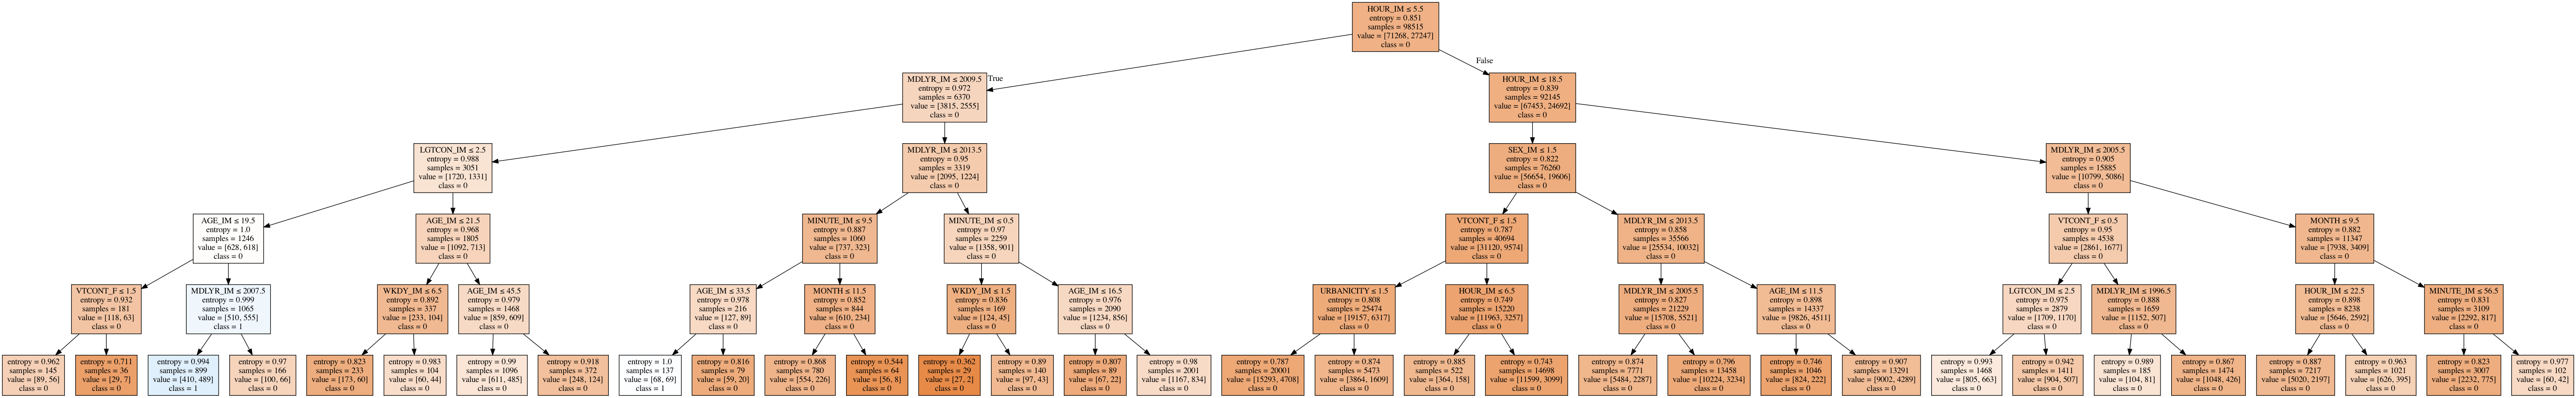

In [31]:
dot_data = StringIO()
export_graphviz(best_tree_model, out_file=dot_data,  
                max_depth=5,feature_names = acc_veh_mot.drop(['INJSEV_IM'], axis=1).columns, class_names=['0','1'], filled=True, rounded=False, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

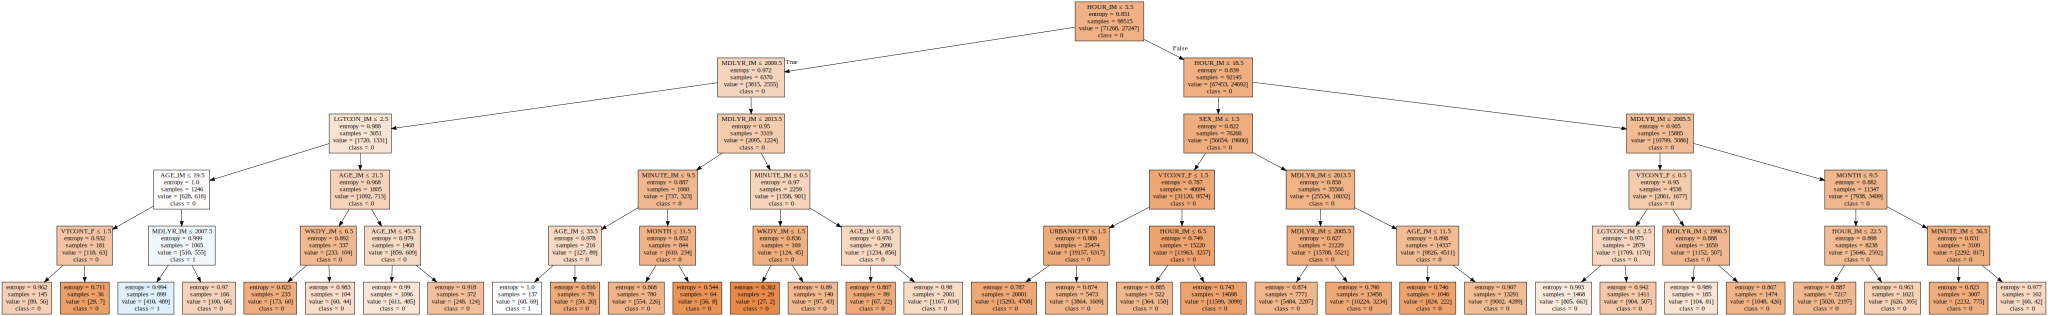

In [32]:
dot_data = StringIO()
graphic_data = export_graphviz(best_tree_model, max_depth=5,feature_names = acc_veh_mot.drop(['INJSEV_IM'], axis=1).columns, class_names=['0','1'], filled=True, rounded=False, special_characters=True)
graph = graphviz.Source(graphic_data)
graph

In [33]:
# Random Forest Classifier model
rf_model = RandomForestClassifier(random_state=99)
rf_model = rf_model.fit(X_train, y_train)

predictions = rf_model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.78      0.96      0.86     17997
           1       0.72      0.25      0.37      6632

    accuracy                           0.77     24629
   macro avg       0.75      0.61      0.61     24629
weighted avg       0.76      0.77      0.73     24629



In [34]:
#KNN Classifier
# Initialize model
knn_model = KNeighborsClassifier(n_neighbors=30, weights='distance')
# Start training
knn_model = knn_model.fit(X_train, y_train)
# Predict
predictions = knn_model.predict(X_test)
# Classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.76      0.98      0.86     17997
           1       0.77      0.17      0.28      6632

    accuracy                           0.76     24629
   macro avg       0.76      0.58      0.57     24629
weighted avg       0.76      0.76      0.70     24629



In [35]:
#Multinomial NB Classifier
# Initilize model
mnb = MultinomialNB()
# Train + Predict
predictions = mnb.fit(X_train, y_train).predict(X_test)
# Classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.73      0.93      0.82     17997
           1       0.29      0.08      0.13      6632

    accuracy                           0.70     24629
   macro avg       0.51      0.50      0.47     24629
weighted avg       0.61      0.70      0.63     24629

